# Comments for Integrated Notebook:
# Paper 1: Focused on achieving high accuracy with Random Forest.
# Paper 2: Gradient Boosting introduced for comparison and advanced performance.
# Paper 3: Emphasis on explaining churn reasons using SHAP.


# 1. Import Necessary Libraries

In [72]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 2. Load and Explore the Data



In [73]:
data_path_20 = 'churn-bigml-20.csv'
data_path_80 = 'churn-bigml-80.csv'

data_20 = pd.read_csv(data_path_20)
data_80 = pd.read_csv(data_path_80)

print("Dataset 20 Overview:")
print(data_20.info())
print("\nDataset 80 Overview:")
print(data_80.info())

Dataset 20 Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   667 non-null    object 
 1   Account length          667 non-null    int64  
 2   Area code               667 non-null    int64  
 3   International plan      667 non-null    object 
 4   Voice mail plan         667 non-null    object 
 5   Number vmail messages   667 non-null    int64  
 6   Total day minutes       667 non-null    float64
 7   Total day calls         667 non-null    int64  
 8   Total day charge        667 non-null    float64
 9   Total eve minutes       667 non-null    float64
 10  Total eve calls         667 non-null    int64  
 11  Total eve charge        667 non-null    float64
 12  Total night minutes     667 non-null    float64
 13  Total night calls       667 non-null    int64  
 14  Total night charge   

# Combine datasets for comprehensive analysis


In [74]:
data = pd.concat([data_20, data_80], ignore_index=True)
print("\nCombined Dataset Overview:")
print(data.info())
data = data.fillna(method='ffill')



Combined Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night 

C:\Users\msi\AppData\Local\Temp\ipykernel_19480\1345113655.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


# 3. Data Preprocessing


Variable Summary:
       State  Account length    Area code International plan Voice mail plan  \
count   3333     3333.000000  3333.000000               3333            3333   
unique    51             NaN          NaN                  2               2   
top       WV             NaN          NaN                 No              No   
freq     106             NaN          NaN               3010            2411   
mean     NaN      101.064806   437.182418                NaN             NaN   
std      NaN       39.822106    42.371290                NaN             NaN   
min      NaN        1.000000   408.000000                NaN             NaN   
25%      NaN       74.000000   408.000000                NaN             NaN   
50%      NaN      101.000000   415.000000                NaN             NaN   
75%      NaN      127.000000   510.000000                NaN             NaN   
max      NaN      243.000000   510.000000                NaN             NaN   

        Number vmail

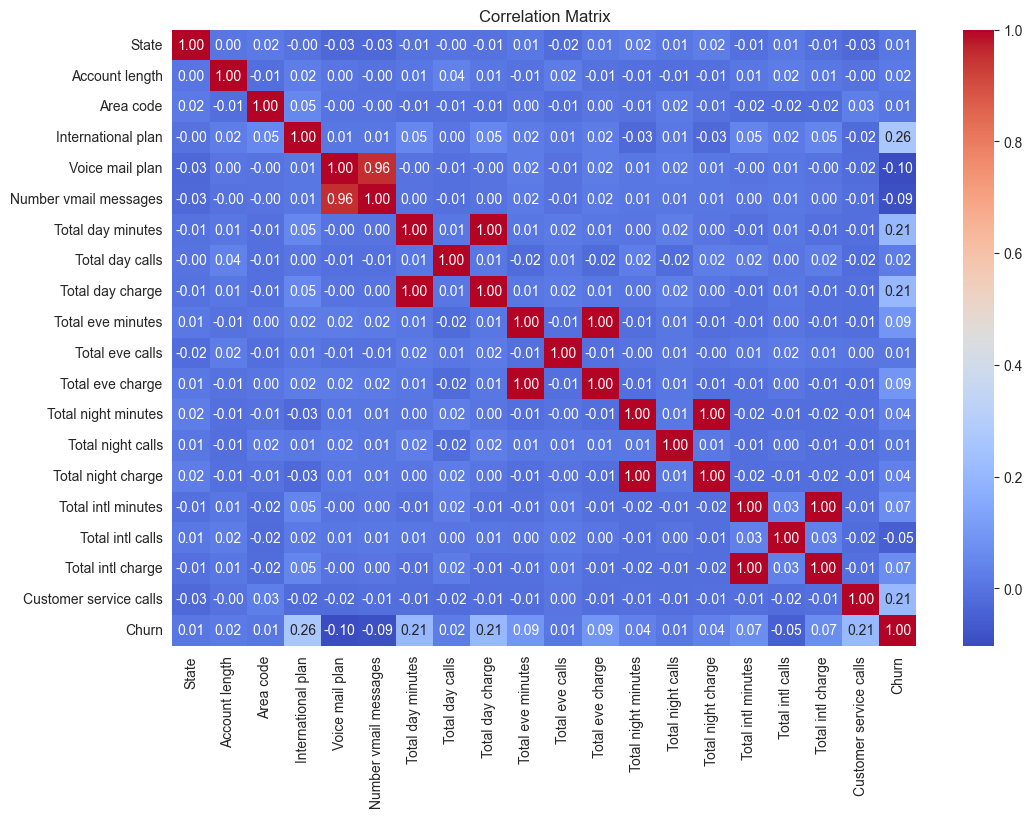

In [75]:
print("\nVariable Summary:")
print(data.describe(include='all'))
# Convert categorical variables to numeric for correlation
data_encoded = data.copy()
categorical_cols = data_encoded.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data_encoded[col] = LabelEncoder().fit_transform(data_encoded[col].astype(str))

# 3.2. Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = data_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

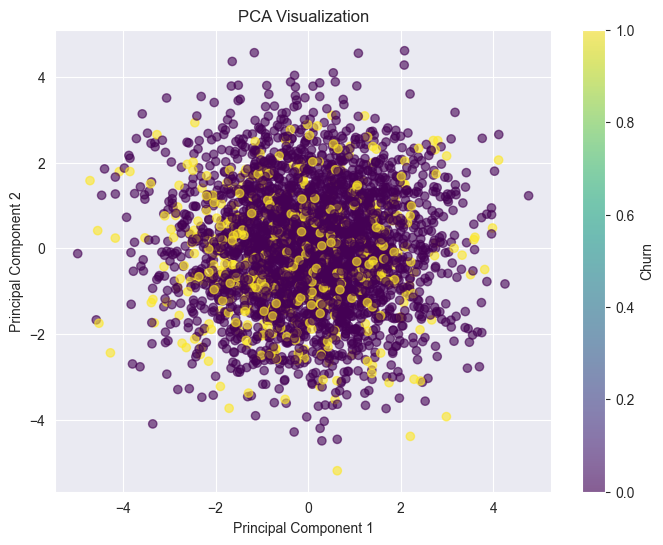

In [76]:
# Ensure all non-numeric columns are encoded
data_encoded = data.copy()
for col in data_encoded.select_dtypes(include=['object']).columns:
    data_encoded[col] = LabelEncoder().fit_transform(data_encoded[col].astype(str))

# 3.3. Visualizing Data with Principal Components
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_encoded.drop(columns=['Churn'], errors='ignore'))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_encoded['Churn'], cmap='viridis', alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Churn')
plt.show()


# Highlight Paper 1: Emphasis on Feature Engineering and Random Forest

In [77]:
# Encode Categorical Data
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


In [78]:
# Split Features and Target
target = 'Churn'  # Assuming 'Churn' is the target column
X = data.drop(columns=[target])
y = data[target]

In [79]:
# Handle Class Imbalance (Paper 1 Reference: SMOTE)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [80]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [81]:
# Evaluate Model
rf_predictions = rf_model.predict(X_test)
print("Random Forest Model Report (Paper 1):")
print(classification_report(y_test, rf_predictions))
joblib.dump(rf_model, "models/rf_model.pkl")  # Save the Random Forest model


Random Forest Model Report (Paper 1):
              precision    recall  f1-score   support

       False       0.92      0.94      0.93       582
        True       0.94      0.92      0.93       558

    accuracy                           0.93      1140
   macro avg       0.93      0.93      0.93      1140
weighted avg       0.93      0.93      0.93      1140



['models/rf_model.pkl']

# 4.6. KNN Classifier

In [82]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
print("\nKNN Classifier Report:")
print(classification_report(y_test, knn_predictions))
joblib.dump(knn_model, "models/knn_model.pkl")  # Save the KNN model



KNN Classifier Report:
              precision    recall  f1-score   support

       False       0.95      0.66      0.78       582
        True       0.73      0.96      0.83       558

    accuracy                           0.81      1140
   macro avg       0.84      0.81      0.80      1140
weighted avg       0.84      0.81      0.80      1140



['models/knn_model.pkl']

# Highlight Paper 2: Advanced Techniques (Gradient Boosting)


In [83]:
# Train Gradient Boosting Classifier
print("\nTraining Gradient Boosting Classifier (Paper 2 Reference):")
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)


Training Gradient Boosting Classifier (Paper 2 Reference):


GradientBoostingClassifier(random_state=42)

In [84]:
gb_predictions = gb_model.predict(X_test)
print("Gradient Boosting Model Report:")
print(classification_report(y_test, gb_predictions))
joblib.dump(knn_model, "models/knn_model.pkl")  # Save the KNN model


Gradient Boosting Model Report:
              precision    recall  f1-score   support

       False       0.87      0.92      0.89       582
        True       0.91      0.85      0.88       558

    accuracy                           0.89      1140
   macro avg       0.89      0.89      0.89      1140
weighted avg       0.89      0.89      0.89      1140



['models/knn_model.pkl']

# Highlight Paper 3: Explainability (SHAP Integration)


In [85]:
# Explainable AI (SHAP Analysis)
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_test)


Generating SHAP Summary Plot (Paper 3 Reference):


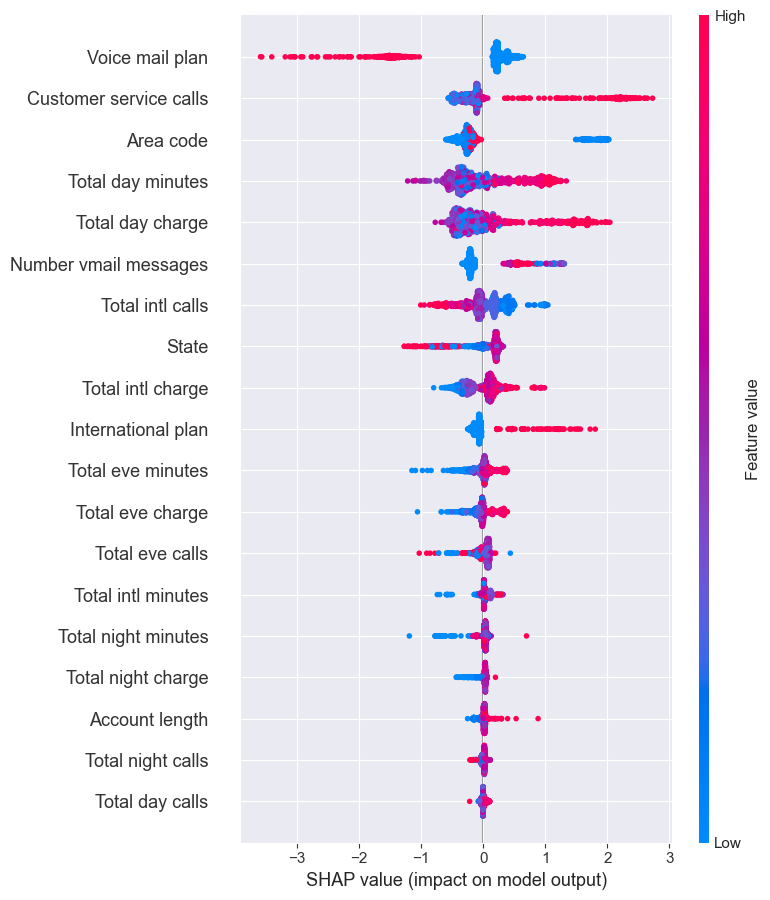

In [86]:
# Visualize SHAP Values
print("\nGenerating SHAP Summary Plot (Paper 3 Reference):")
shap.summary_plot(shap_values, X_test)

pca

In [87]:
# PCA for Feature Importance
pca_rf = PCA(n_components=5)
X_pca_rf = pca_rf.fit_transform(X_scaled)
rf_pca_model = RandomForestClassifier(random_state=42)
rf_pca_model.fit(X_pca_rf, y)
pca_predictions = rf_pca_model.predict(pca_rf.transform(X_test))
print("\nPCA + Random Forest Report:")
print(classification_report(y_test, pca_predictions))


PCA + Random Forest Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       582
        True       0.49      1.00      0.66       558

    accuracy                           0.49      1140
   macro avg       0.24      0.50      0.33      1140
weighted avg       0.24      0.49      0.32      1140



C:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [88]:
# 4.9. Support Vector Machine
# 4.9.1. Linear Kernel
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)
svm_linear_predictions = svm_linear.predict(X_test)
print("\nSVM (Linear) Report:")
print(classification_report(y_test, svm_linear_predictions))
joblib.dump(svm_linear, "models/svm_linear_model.pkl")  # Save the SVM Linear model


# 4.9.2. RBF Kernel
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)
svm_rbf_predictions = svm_rbf.predict(X_test)
print("\nSVM (RBF) Report:")
print(classification_report(y_test, svm_rbf_predictions))
joblib.dump(svm_rbf, "models/svm_rbf_model.pkl")  # Save the SVM RBF model

# 4.10. LightGBM Classifier
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
print("\nLightGBM Report:")
print(classification_report(y_test, lgb_predictions))
joblib.dump(lgb_model, "models/lgb_model.pkl")  # Save the LightGBM model

# 4.11. XGBoost Classifier
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
print("\nXGBoost Report:")
print(classification_report(y_test, xgb_predictions))
joblib.dump(xgb_model, "models/xgb_model.pkl")  # Save the XGBoost model



SVM (Linear) Report:
              precision    recall  f1-score   support

       False       0.77      0.69      0.73       582
        True       0.71      0.79      0.75       558

    accuracy                           0.74      1140
   macro avg       0.74      0.74      0.74      1140
weighted avg       0.74      0.74      0.74      1140


SVM (RBF) Report:
              precision    recall  f1-score   support

       False       0.64      0.88      0.74       582
        True       0.80      0.47      0.59       558

    accuracy                           0.68      1140
   macro avg       0.72      0.68      0.67      1140
weighted avg       0.71      0.68      0.67      1140

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2292, number of negative: 2268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the over

['models/xgb_model.pkl']